
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

from copy import deepcopy

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators import MGGPOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs


evaluator = Evaluator(function=evaluate_TNK)
evaluator.max_workers = 10

# test check options
vocs = deepcopy(tnk_vocs)
gen = MGGPOGenerator(vocs)
gen.options.model.kwargs.use_low_noise_prior = True
gen.options.acq.reference_point = {"y1":1.5,"y2":1.5}
X = Xopt(evaluator=evaluator, generator=gen, vocs=vocs)
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.75, 1.0]}))

for i in range(10):
    print(i)
    X.step()

0
1
2
3
4
5
6
7
8
9


In [2]:
X.generator.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.750000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",0.000064,False,NaN
2,0.750000,1.000000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",0.000010,False,NaN
3,2.401430,0.277434,2.401430,0.277434,4.870459,3.664971,"[1, 2, 3]",0.000040,False,dummy_constant
4,2.758150,0.328828,2.758150,0.328828,6.747715,5.128543,"[1, 2, 3]",0.000012,False,dummy_constant
5,3.100600,0.373300,3.100600,0.373300,8.787013,6.779171,"[1, 2, 3]",0.000010,False,dummy_constant
...,...,...,...,...,...,...,...,...,...,...
98,0.434780,0.957441,0.434780,0.957441,0.019804,0.213506,"[1, 2, 3]",0.000009,False,dummy_constant
99,0.478828,0.883899,0.478828,0.883899,0.019490,0.147827,"[1, 2, 3]",0.000009,False,dummy_constant
100,0.478828,0.959962,0.478828,0.959962,0.107217,0.212013,"[1, 2, 3]",0.000007,False,dummy_constant
101,0.478828,0.947414,0.478828,0.947414,0.091027,0.200627,"[1, 2, 3]",0.000008,False,dummy_constant


## plot results


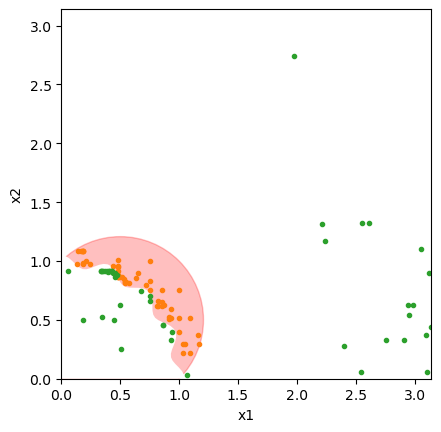

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

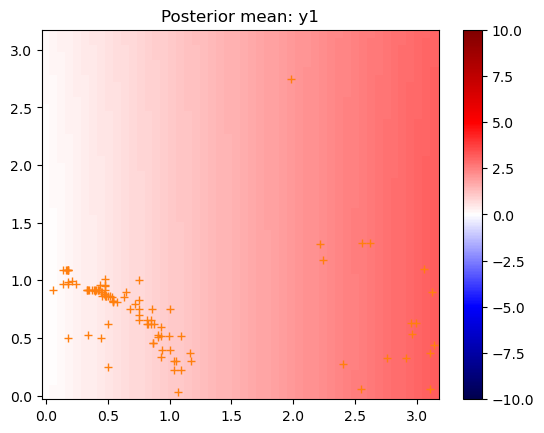

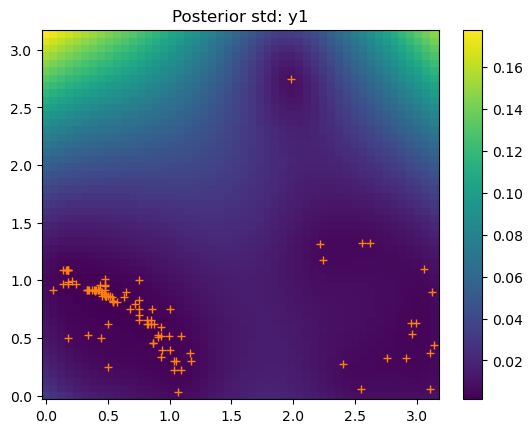

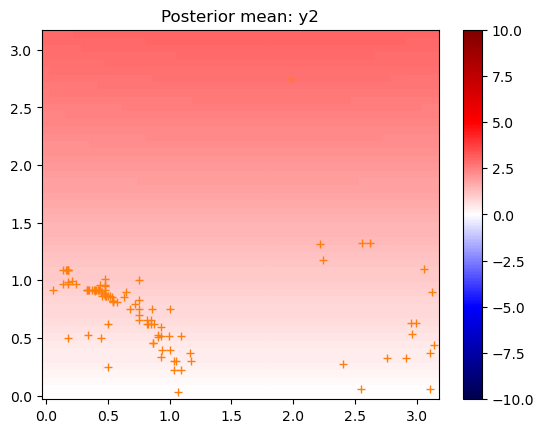

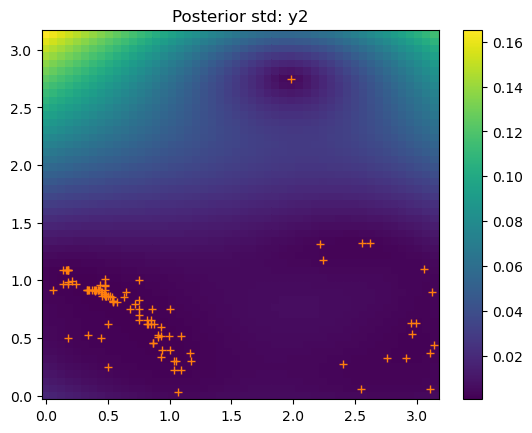

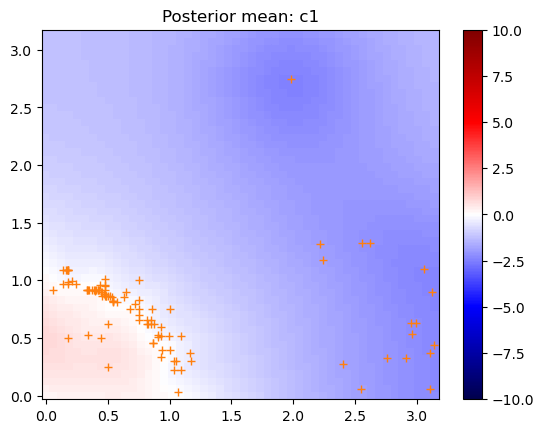

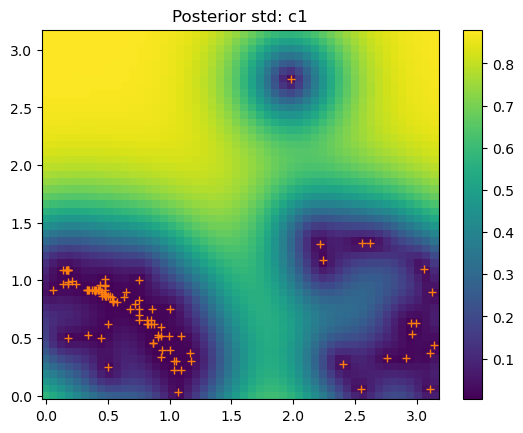

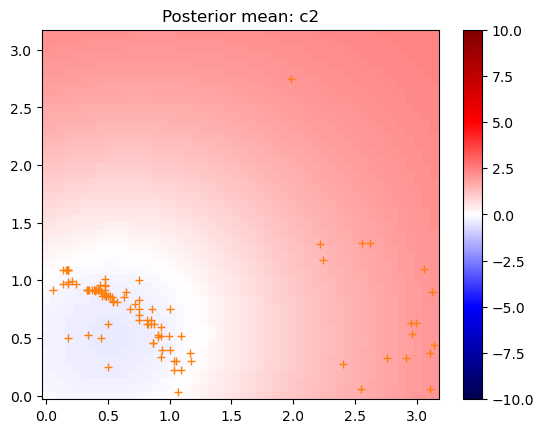

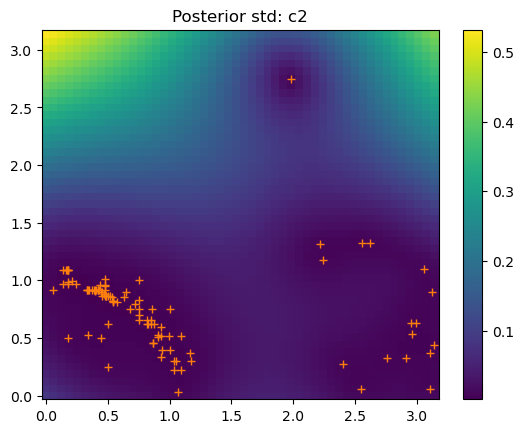

In [4]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.train_model(X.generator.data)

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n), cmap="seismic",vmin=-10.0,
                      vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

        fig2, ax2 = plt.subplots()
        ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax2.pcolor(xx, yy, std[:, i].reshape(n, n))
        fig2.colorbar(c)
        ax2.set_title(f"Posterior std: {outputs[i]}")

[[1.         0.32656842]]


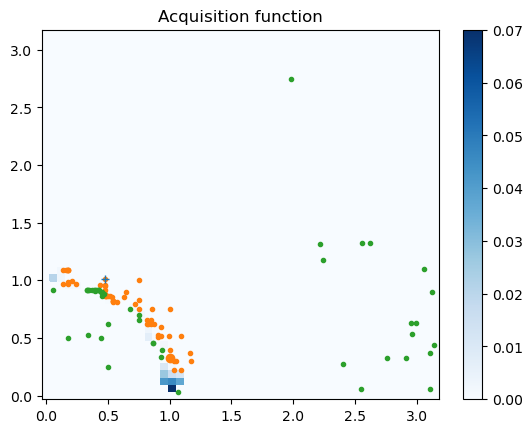

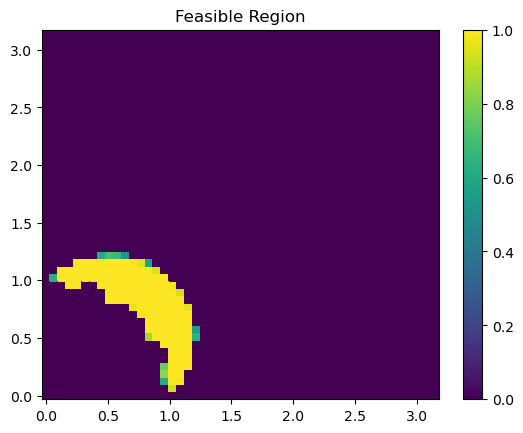

In [5]:
# plot the acquisition function
from xopt.generators.bayesian.utils import feasibility

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
    ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

    ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, tnk_vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

candidate = X.generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")